## _Evaluation Metrics_

In [1]:
import sys, os, glob, yaml

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import pprint
from tqdm import tqdm
import trackml.dataset

In [4]:
import torch
import torchmetrics
import pytorch_lightning as pl
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import itertools

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
# append parent dir
sys.path.append('..')

In [7]:
from src.metric_utils import compute_metrics, plot_metrics, plot_outputs_roc, plot_model_output

### _Classifier Evaluation_

Metrics to evaluate the GNN networks:

- Accuracy/ACC = $TP+TN/TP+TN+FP+FN$
- sensitivity, recall, hit rate, or true positive rate ($TPR = 1 - FNR$)
- specificity, selectivity or true negative rate ($TNR = 1 - FPR$)
- miss rate or false negative rate ($FNR = 1 - TPR$)
- fall-out or false positive rate ($FPR = 1 - TNR$)
- F1-score = $2 \times (\text{PPV} \times \text{TPR})/(\text{PPV} + \text{TPR})$
- Efficiency/Recall/Sensitivity/Hit Rate: $TPR = TP/(TP+FN)$
- Purity/Precision/Positive Predictive Value: $PPV = TP/(TP+FP$
- AUC-ROC Curve $\equiv$ FPR ($x-$axis) v.s. TPR ($y-$axis) plot
- AUC-PRC Curve $\equiv$ TPR ($x-$axis) v.s. PPV ($y-$axis) plot


Use `tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()` to directly access TN, FP, FN and TP using Scikit-learn.

### _Inference: BNNBuilder_

If _**GNNBuilder**_ callback has been run during training, just load data from `dnn_processed/test` and extract `scores` and `y_pid ~ truth` and simply run the following metrics.

In [28]:
# fetch all files
inputdir = "run_all/dnn_processed_bn/test"
dnn_files = sorted(glob.glob(os.path.join(inputdir, "*")))

- _Load all `truth` and `scores` from the `testset` from the `DNN` stage_

In [29]:
scoresl, truthsl = [], []

for e in range(len(dnn_files)):
    
    # logging
    if e !=0 and e%1000==0:
        print("Processed Batches: ", e)
    
    dnn_data = torch.load(dnn_files[e], map_location=device)
    
    truth = dnn_data.y_pid
    score = dnn_data.scores
    score = score[:truth.size(0)]
    
    # append each batch
    scoresl.append(score)
    truthsl.append(truth)

Processed Batches:  1000
Processed Batches:  2000
Processed Batches:  3000
Processed Batches:  4000


In [30]:
scores = torch.cat(scoresl)
truths = torch.cat(truthsl)

### _Evaluation Metrics_

In [31]:
from src.metric_utils import compute_metrics, plot_metrics, plot_outputs_roc, plot_model_output

In [32]:
# save scores and truths as .npy files
np.save("bn_dnn_scores.npy", scores.numpy())
np.save("bn_dnn_truths.npy", truths.numpy())

In [33]:
# torch to numpy
scores = scores.numpy()
truths = truths.numpy()

In [34]:
metrics = compute_metrics(scores,truths,threshold=0.5)

In [35]:
# Curves
# metrics.prc_precision, metrics.prc_recall, metrics.prc_thresh
# metrics.roc_tpr, metrics.roc_fpr, metrics.roc_thresh

In [36]:
metrics.accuracy

0.9164144873795846

In [37]:
metrics.recall

0.6629192961482804

In [38]:
metrics.precision

0.893105786073915

In [39]:
metrics.f1

0.7609865237449079

### _(a) - Plot Metrics_

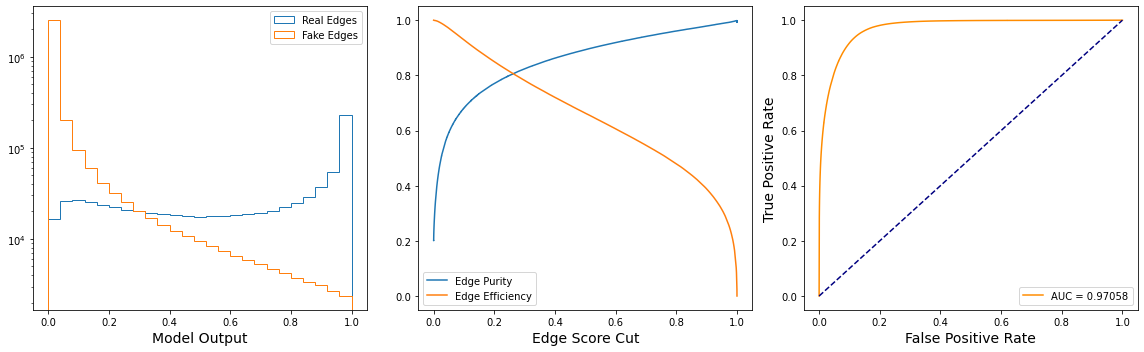

In [40]:
plot_metrics(scores,truths, metrics, name="bn_dnn")

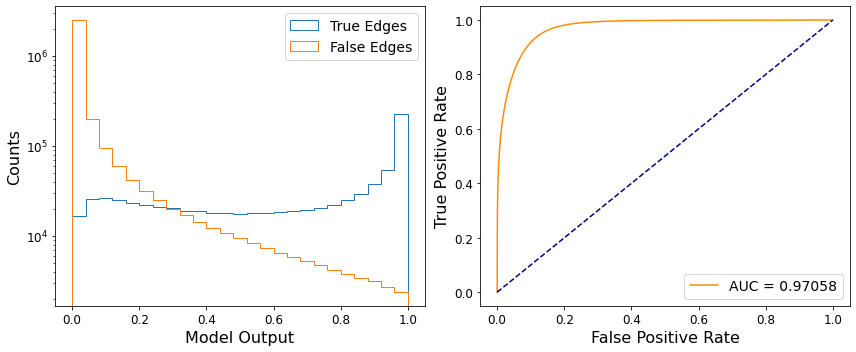

In [41]:
plot_outputs_roc(scores,truths, metrics, name="bn_dnn")

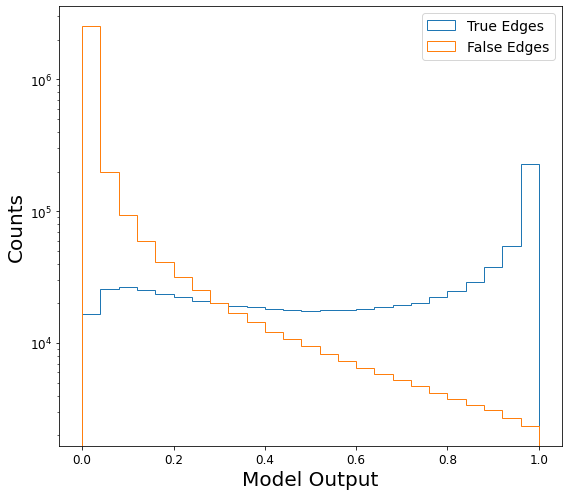

In [42]:
plot_model_output(scores, truths, name="bn_dnn")

### _(b) - S/B Suppression_

Background rejection rate (1/FPR) is given as $1/\epsilon_{bkg}$ where $\epsilon_{bkg}$ is the fraction of fake edges that pass the classification requirement. Signal efficiency (TPR ~ Recall) ($\epsilon_{sig}$) is defined as the number of true edges above a given classification score cut over the total number of true edges. What we have?

- Signal Efficiency = $\epsilon_{sig}$ = TPR ~ Recall 
- Background Rejection = $1 - \epsilon_{bkg}$ ???
- Background Rejection Rate = $1/\epsilon_{bkg}$ = 1/FPR


First apply a edge score cut to binarized the `scores`, we will call it `preds`. The count number of false or true edges that pass this cut. Then calculated background rejection rate and signal efficiency. For making a plot one can do calculations in batch by batch mode on the test dataset.

In [43]:
sig = metrics.roc_tpr

In [44]:
bkg_rejection = 1/metrics.roc_fpr

/tmp/ipykernel_888325/2780880391.py:1: RuntimeWarning: divide by zero encountered in true_divide
  bkg_rejection = 1/metrics.roc_fpr


In [45]:
# cut off eff < 0.2 or 0.5
sig_mask = sig > 0.3

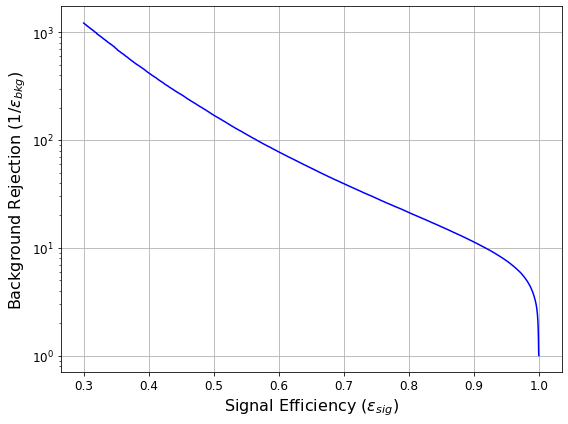

In [46]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
ax.plot(sig[sig_mask], bkg_rejection[sig_mask], color="blue")

# Axes Params
ax.set_xlabel("Signal Efficiency ($\epsilon_{sig}$)", fontsize=16)
ax.set_ylabel("Background Rejection ($1/\epsilon_{bkg}$)", fontsize=16)
ax.set_yscale('log')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)
ax.grid(True)

# Figure Params
fig.tight_layout()
fig.savefig("bn_dnn_SB.pdf")

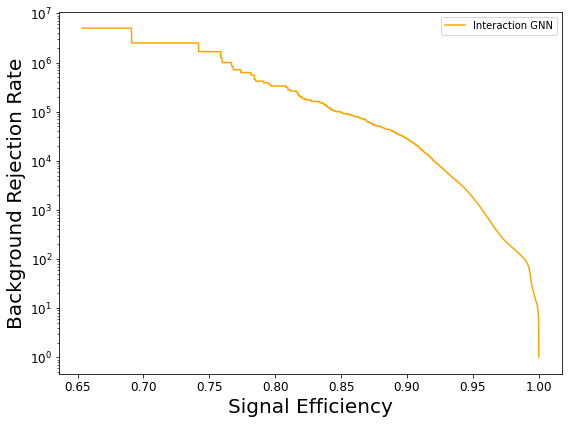

In [26]:
plt.close()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))

ax.plot(sig[sig_mask], bkg_rejection[sig_mask], label="Interaction GNN", color="orange")

# Axes Params
ax.set_xlabel("Signal Efficiency", fontsize=20)
ax.set_ylabel("Background Rejection Rate", fontsize=20)
ax.set_yscale('log')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)
ax.grid(False)
ax.legend()

# Figure Params
fig.tight_layout()
fig.savefig("gnn_SB.pdf")